In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import takewhile
from PIL import ImageFont
from matplotlib.font_manager import findfont, FontProperties
from datetime import datetime

plt.style.use('default')

# Importa dati

### Protezione civile

In [2]:
# dati nazionali sui contagi
df_IT = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

In [3]:
df_IT.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_IT.index = pd.to_datetime(df_IT['data'])

df_IT.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')

### Istituto Superiore di Sanità

In [5]:
df_assoluti = pd.read_csv('../dati/dati_ISS_complessivi.csv', sep=';')

# ricava i tassi, dividendo per la popolazione vaccinati e non vaccinata
tassi = (7/30)*10**5*np.transpose([df_assoluti['casi non vaccinati']/df_assoluti['non vaccinati'],
         df_assoluti['casi vaccinati']/df_assoluti['vaccinati completo'],                  
         df_assoluti['decessi non vaccinati']/df_assoluti['non vaccinati'],
         df_assoluti['decessi vaccinati']/df_assoluti['vaccinati completo']])

df_tassi = pd.DataFrame(tassi)

df_tassi.columns = ['Casi, non vaccinati',
                    'Casi, vaccinati',
                    'Deceduti, non vaccinati',
                    'Deceduti, vaccinati']

df_tassi.index = pd.to_datetime(df_assoluti['data'], format='%Y/%m/%d')
df_tassi = df_tassi.iloc[::-1]

casi_2021_vacc = np.array(df_tassi['Casi, vaccinati'])
casi_2021_novacc = np.array(df_tassi['Casi, non vaccinati'])
dec_2021_vacc = np.array(df_tassi['Deceduti, vaccinati'])
dec_2021_novacc = np.array(df_tassi['Deceduti, non vaccinati'])

xgrid_2021 = np.arange(0, 7*len(casi_2021_vacc), 7)

# Andamento curve epidemiche

### Funzioni per plot

In [6]:
def watermark_specs(figure, watermark):
    # Get the default Matplotlib font
    default_font = findfont(FontProperties(family=['sans-serif']))
    
    # Fraction of the image where the Watermark is placed
    figure_fraction = 0.6
    
    # Get Figure width, height (Pixels)
    figure_wd = figure.get_figwidth() * figure.dpi
    figure_ht = figure.get_figheight() * figure.dpi
    
    # Get Watermark width (Pixels)
    watermark_wd = int(figure_fraction * figure_wd)

    # Calculate the scaled fontsize - iterate until the text size is larger than the text width and take the max value
    fontsize = max(takewhile(lambda i: ImageFont.truetype(default_font, i).getsize(watermark)[0] < watermark_wd, 
                    range(1, watermark_wd))) - 1
    # Calculate appropriate rotation and convert to degree (r * 180°/pi)
    angle = np.arctan(figure_ht/figure_wd)*(180/np.pi)

    # Multiply by -1 to flip text horizontally
    angle *= -1

    print(f"watermark fontsize: {fontsize}, angle:{round(angle, 2)}")
    return fontsize, angle

def add_watermark(figure, axis_font_size):
    watermark = 'github.com/apalladi/covid_monitoraggio_vaccini'
    # Get the scaled watermark fontsize and angle
    fontsize, angle = watermark_specs(figure, watermark)
    figure.text(0.5, 
                0.5, 
                watermark,
                fontsize=fontsize, 
                color='gray', 
                alpha=0.25,
                ha='center', 
                va='center', 
                rotation=angle, 
                zorder=0
                )

    # explicit link and last update date at the bottom
    last_update = datetime.today().strftime('%d-%m-%Y %H:%M')
    watermark_btm = r'$\bf{Fonte:}$ https://github.com/apalladi/covid_vaccini_monitoraggio'
    watermark_btm += f'\n Ultimo aggiornamento: {last_update}'
    figure.text(0.5, 
                -0.06, 
                watermark_btm,
                fontsize=axis_font_size,
                color='darkslategray', 
                ha="center", 
                va="bottom"
                )


### Casi e decessi 2020

In [7]:
abitanti_over12 = 540*10**5

mask_2020 = (df_IT.index >= '2020-06-15') & (df_IT.index <= '2020-12-31')
df_2020 = df_IT[mask_2020]
df_2020 = df_2020[['totale_casi', 'deceduti']].diff().rolling(window=30).mean()
df_2020 = df_2020*7/(abitanti_over12/(10**5))
df_2020.columns = ['casi', 'decessi']

casi_2020 = np.array(df_2020['casi'])[30:]
dec_2020 = np.array(df_2020['decessi'])[30:]

xgrid_2020 = np.arange(0, len(casi_2020))
x_label1 = np.arange(15, 170, 30)
x_label2 = ['Ago', 'Set', 'Ott', 'Nov', 'Dic', 'Gen']

### Casi e decessi 2021

watermark fontsize: 21, angle:-23.96


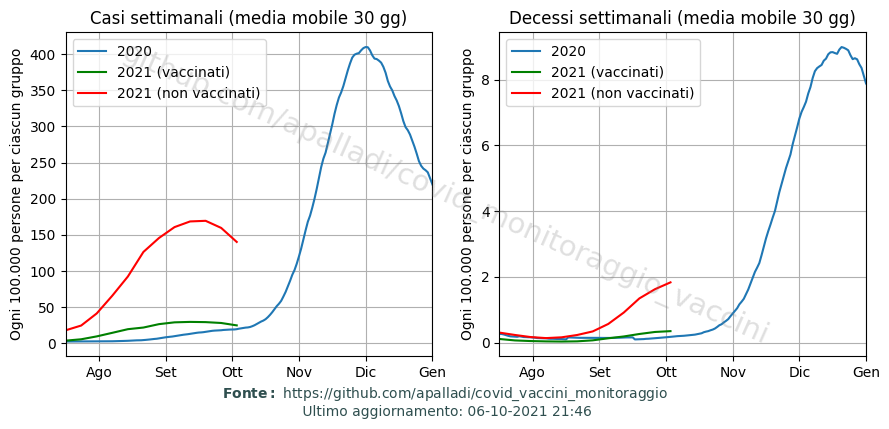

In [8]:
fig = plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(xgrid_2020, casi_2020, label='2020')
plt.plot(xgrid_2021, casi_2021_vacc, label='2021 (vaccinati)', color='green')
plt.plot(xgrid_2021, casi_2021_novacc, label='2021 (non vaccinati)', color='red')
plt.xticks(x_label1, x_label2)
plt.title('Casi settimanali (media mobile 30 gg)')
plt.ylabel('Ogni 100.000 persone per ciascun gruppo')
plt.legend()
plt.xlim(0, 165)
plt.grid()  

plt.subplot(1, 2, 2)
plt.plot(xgrid_2020, dec_2020, label='2020')
plt.plot(xgrid_2021, dec_2021_vacc, label='2021 (vaccinati)', color='green')
plt.plot(xgrid_2021, dec_2021_novacc, label='2021 (non vaccinati)', color='red')
plt.xticks(x_label1, x_label2)
plt.title('Decessi settimanali (media mobile 30 gg)')
plt.ylabel('Ogni 100.000 persone per ciascun gruppo')
plt.legend()
plt.xlim(0, 165)
plt.grid()

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/confrontro_2020_2021.png', dpi=300, bbox_inches="tight")
plt.show()